# Example Training & Evaluation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from juliacall import Main as jl  # Must load before torch
jl.seval("using SensorUtils")

from sac.environment import NPulse_Environment
from sac.agent import Agent
from sac.utilities import instant_reward_training, policy_samples

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
chkpt_dir = "tmp/"  # Dir for saving checkpoints

## Environment Parameters

In [3]:
spin = 1/2  # Spin manifold
dims = int(2 * spin + 1)  # Dimensions
omega = np.sqrt(2) * 2 * np.pi * 1e3  # Precession freq. [rad/s]
Omega0 = 2 * np.pi  # Reference Rabi freq. [rad/s]
T_lim = 10 * 2 * np.pi / Omega0  # Total pulse duration [s]
N_pulses = 10  # Number of pulses within duration
T_Omega = T_lim / N_pulses  # Duration of each pulse [s]

# Boundaries for each parameter, (\Omega, \phi, \delta)
bounds = [(0, 5 * Omega0), (0, np.pi / 2), (0.99 * omega, 1.01 * omega)]

# Decoherence
Js = jl.spin_matrices(jl.rationalize(spin))  # Spin ops (Jx, Jy, Jz)
Jp, Jm = jl.spin_matrices_pm(jl.rationalize(spin))  # Ladder ops (J+, J-)
Ls = [Jm, Js[2]]  # Jump operators
gamma_s = [5e-2 * 2 * np.pi / T_lim, 5e-2 * 2 * np.pi / T_lim]  # Decay rates [rad/s]

# Initial state
rho0 = np.zeros((dims, dims), dtype=np.complex128)
rho0[0, 0] = 1.

# Build environment
env = NPulse_Environment(spin, omega, Ls, gamma_s, rho0, T_Omega, T_lim, N_pulses,
                         bounds, chkpt_dir)
env.reset()
env.save_params()

## Agent

In [4]:
tau = 0.005  # Target-value network scaling
reward_scale = 10  # Entropy term
batch_size = 512
gamma = 0.99  # Discount factor
nn_dims = [256, 256, 256]

agent = Agent(env.observation_shape[0], env.action_shape[0], reward_scale, chkpt_dir,
              gamma=gamma, tau=tau, alpha=1e-3, beta=1e-3, batch_size=batch_size,
              mem_size=int(1e6), a_dims=nn_dims, c_dims=nn_dims, v_dims=nn_dims,
              print_out=False)
agent.reset_buffer()
agent.save_agent_params()

## Training

In [5]:
n_its = 1500  # number of iterations
prnt_ep = False  # Print results of each episode

rewards, rewards_avg = instant_reward_training(n_its, env, agent, prnt_ep=prnt_ep)

In [6]:
# Save parameters
agent.memory.save_buffer()
ax = [i + 1 for i in range(n_its)]
np.savez(chkpt_dir + "learning_curve", allow_pickle=False,
            rewards=rewards, roll_avg=rewards_avg, it_ax=ax)

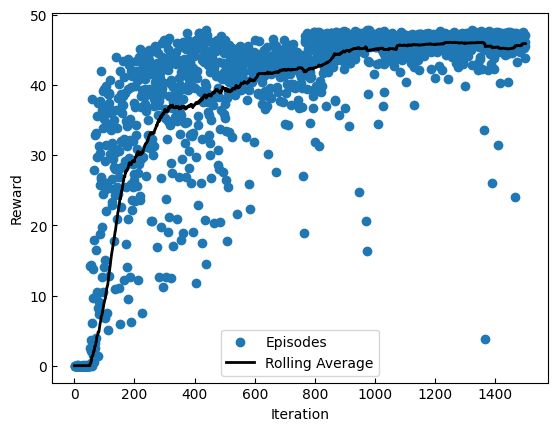

In [7]:
f = plt.figure()
plt.scatter(ax, rewards, marker="o", label="Episodes")
plt.plot(ax, rewards_avg, lw=2, c="k", label="Rolling Average")
plt.xlabel("Iteration")
plt.ylabel("Reward")

plt.legend(loc="best")
plt.tick_params(direction="in")  # Set grid-ticks inward
plt.show()
plt.close(f)

# Evaluate Policy

Here we will sample `samples` many trajectories from the trained agent for plotting.

In [8]:
qfi_n = 20  # Number of QFI points to sample
samples = 50  # Number of trajectories to sample

t_ax = np.linspace(0, env.T_lim, num=1000, endpoint=True)  # Time axis
t_qax = np.linspace(0, env.T_lim, num=qfi_n, endpoint=True)  # QFI time axis


# Sampled Trajectories
acts, rhos, qfis, ts = policy_samples(env, agent, t_ax, t_qax, samples=samples)

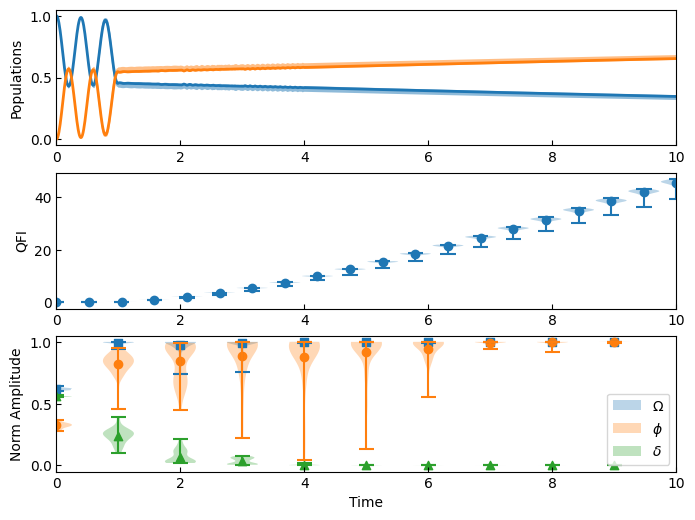

In [9]:
fig, ax = plt.subplots(3, 1, figsize=(8, 6))
t_scale = env.T_Omega  # Time axis scaling

# --- Populations ---
# Extract populations from density-matrices
colors = ["b", "r", "g"]
pops = np.empty((env.dims, len(rhos), len(t_ax)))
for i, r in enumerate(rhos):
    for d in range(env.dims):
        pops[d, i, :] = np.array([np.real(rr[d, d]) for rr in r])

# Statistics
upper = np.percentile(pops, 75, axis=1) 
lower = np.percentile(pops, 25, axis=1)
avg = np.mean(pops, axis=1)

# Plot
for d in range(env.dims):
    ax[0].fill_between(t_ax / t_scale, upper[d, :], lower[d, :], alpha=0.5)
    ax[0].plot(t_ax / t_scale, avg[d, :], lw=2)


# --- QFI ---
qfis_np = np.concatenate(qfis)  # As array
qfi_avgs = np.mean(qfis_np, axis=0)
ax[1].violinplot(qfis_np, positions = t_qax / t_scale)
ax[1].scatter(t_qax / t_scale, qfi_avgs, marker="o")


# --- Parameter Violins ---
# Parameter boundaries for scaling
maxs, mins = env.a_maxs, env.a_mins
Ou, pu, du = maxs[0], maxs[1], maxs[2]
Ol, pl, dl = mins[0], mins[1], mins[2]

# Parse sampled actions
Oms, phis, dels = [], [], []
for a in acts:
    Om, phi, de = a
    Oms.append(Om.reshape(-1))
    phis.append(phi.reshape(-1))
    dels.append(de.reshape(-1))
Oms = np.stack(Oms)
phis = np.stack(phis)
dels = np.stack(dels)

# Plot
vp1 = ax[2].violinplot((Oms - Ol) / (Ou - Ol), positions = ts / t_scale)
vp2 = ax[2].violinplot((phis - pl) / (pu - pl), positions = ts / t_scale)
vp3 = ax[2].violinplot((dels - dl) / (du - dl), positions = ts / t_scale)
ax[2].scatter(ts / t_scale, (np.mean(Oms, axis=0) - Ol) / (Ou - Ol), marker="s")
ax[2].scatter(ts / t_scale, (np.mean(phis, axis=0) - pl) / (pu - pl), marker="o")
ax[2].scatter(ts / t_scale, (np.mean(dels, axis=0) - dl) / (du - dl), marker="^")


# --- Settings ---
ax[0].set_ylabel("Populations")
ax[0].set_ylim([-0.05, 1.05])
ax[1].set_ylabel("QFI")
ax[2].set_ylabel("Norm Amplitude")
ax[2].set_xlabel("Time")
ax[2].set_ylim([-0.05, 1.05])

for a in ax:
    a.set_xlim([0, env.T_lim / t_scale])
    a.tick_params(direction="in")  # Set grid-ticks inward
plt.legend([vp1['bodies'][0], vp2['bodies'][0], vp3['bodies'][0]],
            ["$\\Omega$", "$\\phi$", "$\\delta$"], loc="best")

plt.show()
plt.close(fig)